In [38]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd

import sys
sys.path.append('../AJA')
import AJA as aja

In [39]:
from sklearn.preprocessing import StandardScaler


def f(df_nodes, df_edges):

    df = df_nodes

    scaler = StandardScaler()

    # sentence length normalized
    df['sentence_length'] = df['text'].apply(lambda s: len(s.split()))
    df['sentence_length'] = scaler.fit_transform(df['sentence_length'].values.reshape(-1, 1))

    # speaker hot-one encoding
    one_hot_encoded = pd.get_dummies(df['speaker_int'], prefix='speaker')
    df = df.drop('speaker_int', axis=1)
    df = df.drop('speaker_text', axis=1)
    df = pd.concat([df, one_hot_encoded], axis=1)
    return df

def g(df):
    new_df = pd.DataFrame({
        'transcription': df['transcription'],
        'start': df['end'],
        'end': df['start'],
        'type_int': 16 + df['type_int'],
        'type_text': df['type_text'] + "_reverse"
    })
    result_df = pd.concat([df, new_df], ignore_index=True)
    return result_df


In [40]:
train_graphs, validation_graphs, test_graphs = aja.get_graphs(f, g, 0.3)

In [5]:
import pickle

# Save train_graphs
with open('pickle/train_graphs.pkl', 'wb') as f:
    pickle.dump(train_graphs, f)

# Save validation_graphs
with open('pickle/validation_graphs.pkl', 'wb') as f:
    pickle.dump(validation_graphs, f)

# Save test_graphs
with open('pickle/test_graphs.pkl', 'wb') as f:
    pickle.dump(test_graphs, f)


In [13]:
import pickle

# Load train_graphs
with open('pickle/train_graphs.pkl', 'rb') as f:
    train_graphs = pickle.load(f)

# Load validation_graphs
with open('pickle/validation_graphs.pkl', 'rb') as f:
    validation_graphs = pickle.load(f)

# Load test_graphs
with open('pickle/test_graphs.pkl', 'rb') as f:
    test_graphs = pickle.load(f)


In [14]:
# on check la forme des input
train_graphs['ES2002b']

Data(x=[897, 389], edge_index=[32], y=[897])

In [15]:
class MultiChannelsGCN(torch.nn.Module):
    
    def __init__(self, channels, input_dim, post_conv_dim, output_dim, identity=False):
        super(MultiChannelsGCN, self).__init__()
        self.identity = identity
        self.channels = channels
        self.input_dim = input_dim
        self.post_conv_dim = post_conv_dim
        self.output_dim = output_dim
        self.GCN = nn.ModuleList([GCNConv(input_dim, post_conv_dim) for _ in range(channels)])
        if identity:
            self.dense = nn.Linear(post_conv_dim * (channels + 1), output_dim)
            self.denseID = nn.Linear(input_dim, post_conv_dim)
        else:
            self.dense = nn.Linear(post_conv_dim * channels, output_dim)

    def forward(self, nodes, edges):
        X = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.post_conv_dim)
            else:
                x = F.relu(self.GCN[k](nodes, edges[k]))
            X.append(x)
        if self.identity:
            X.append(F.relu(self.denseID(nodes)))
        concat = torch.cat(X, dim=1)
        return F.relu(self.dense(concat))

In [16]:
# on définie son plus beau modèle

class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.threshold = 0.5
        self.GCN1 = MultiChannelsGCN(channels, input_dim, 50, 20, identity=True)
        self.dense1 = nn.Linear(20,1)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        x = self.GCN1(nodes, edges)
        x = self.dense1(x)
        return x

    def set_threshold(self, t):
        self.threshold = t

    def predict(self, graph):
        self.eval()
        with torch.no_grad():
            logits = self.forward(graph)
            predictions = torch.sigmoid(logits)
        return np.array((predictions > self.threshold).int()).flatten()

In [17]:
# Charger l'extension autoreload
%load_ext autoreload

# Configurer autoreload pour recharger tous les modules avant l'exécution de chaque cellule
%autoreload 2

In [18]:
train_graphs

{'ES2008d': Data(x=[1364, 389], edge_index=[32], y=[1364]),
 'ES2010d': Data(x=[563, 389], edge_index=[32], y=[563]),
 'IS1002d': Data(x=[497, 389], edge_index=[32], y=[497]),
 'IS1007a': Data(x=[336, 389], edge_index=[32], y=[336]),
 'ES2005b': Data(x=[815, 389], edge_index=[32], y=[815]),
 'IS1004a': Data(x=[196, 389], edge_index=[32], y=[196]),
 'ES2008c': Data(x=[860, 389], edge_index=[32], y=[860]),
 'IS1005b': Data(x=[614, 389], edge_index=[32], y=[614]),
 'ES2010c': Data(x=[722, 389], edge_index=[32], y=[722]),
 'ES2016d': Data(x=[647, 389], edge_index=[32], y=[647]),
 'ES2007a': Data(x=[415, 389], edge_index=[32], y=[415]),
 'TS3010d': Data(x=[649, 389], edge_index=[32], y=[649]),
 'ES2005d': Data(x=[669, 389], edge_index=[32], y=[669]),
 'ES2002b': Data(x=[897, 389], edge_index=[32], y=[897]),
 'IS1005c': Data(x=[572, 389], edge_index=[32], y=[572]),
 'IS1007d': Data(x=[717, 389], edge_index=[32], y=[717]),
 'IS1006d': Data(x=[1148, 389], edge_index=[32], y=[1148]),
 'ES2016b'

In [19]:
# Move the instantiation of the model outside the training loop
model = NodeClassifier(32, 389)
model.set_threshold(0.59)

# Move the model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Use DataLoader to create batches of data
train_loader = DataLoader(list(train_graphs.values()), batch_size=1, shuffle=True)
N_train = len(train_loader)
validation_loader = DataLoader(list(validation_graphs.values()), batch_size=1, shuffle=False)
N_validation = len(validation_loader)

# Define the loss function and optimizer
alpha = 0.2
gamma = 5
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor((1 - alpha) / alpha), reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

from sklearn.metrics import f1_score
import time

# Train the model
for epoch in range(8):
    print('- Epoch', f'{epoch:03d}', '-')
   
    start_time = time.time()
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / N_train
    end_time = time.time()

    training_time = end_time - start_time
    print('Training time:', training_time, 'seconds')
    print('Loss:', f'{average_loss:.4f}')

    # Evaluate the model on the training set
    start_time = time.time()
    model.eval()
    f1_moyen_train = 0
    for data in train_loader:
        data = data.to(device)
        y_pred = model.predict(data)
        y_true = data.y.cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        f1_moyen_train += f1
    f1_moyen_train /= N_train

    # Evaluate the model on the validation set
    model.eval()
    f1_moyen_valid = 0
    for data in validation_loader:
        data = data.to(device)
        y_pred = model.predict(data)
        y_true = data.y.cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        f1_moyen_valid += f1
    f1_moyen_valid /= N_validation
    end_time = time.time()

    evaluation_time = end_time - start_time
    print('Evaluation time:', training_time, 'seconds')

    print('F1 train:', f1_moyen_train)
    print('F1 valid:', f1_moyen_valid)
    torch.save(model.state_dict(), "training_states/" + str(epoch) + ".pth")
    average_loss = total_loss / len(train_loader)
    print('')



- Epoch 000 -
Training time: 8.167797088623047 seconds
Loss: 0.7497
Evaluation time: 8.167797088623047 seconds
F1 train: 0.559379357203108
F1 valid: 0.5879434425039411

- Epoch 001 -
Training time: 7.880878210067749 seconds
Loss: 0.6779
Evaluation time: 7.880878210067749 seconds
F1 train: 0.565696541284851
F1 valid: 0.5946770778721908

- Epoch 002 -
Training time: 7.837092399597168 seconds
Loss: 0.6585
Evaluation time: 7.837092399597168 seconds
F1 train: 0.5888621571246229
F1 valid: 0.6045891907480099

- Epoch 003 -
Training time: 8.428555250167847 seconds
Loss: 0.6386
Evaluation time: 8.428555250167847 seconds
F1 train: 0.6096276346678647
F1 valid: 0.610277658132201

- Epoch 004 -
Training time: 7.836430311203003 seconds
Loss: 0.6037
Evaluation time: 7.836430311203003 seconds
F1 train: 0.6172937102551277
F1 valid: 0.6000991874673829

- Epoch 005 -
Training time: 7.803037166595459 seconds
Loss: 0.5552
Evaluation time: 7.803037166595459 seconds
F1 train: 0.649750935474656
F1 valid: 0.60

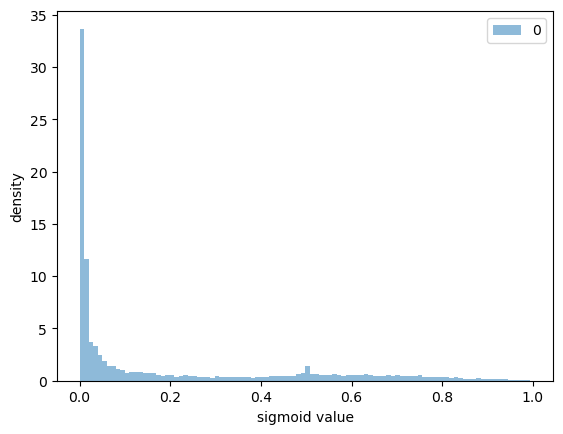

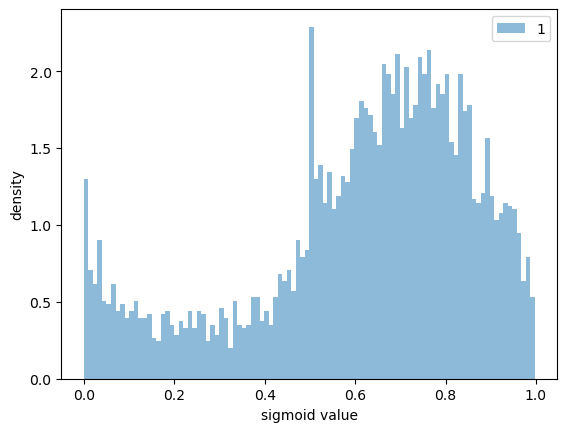

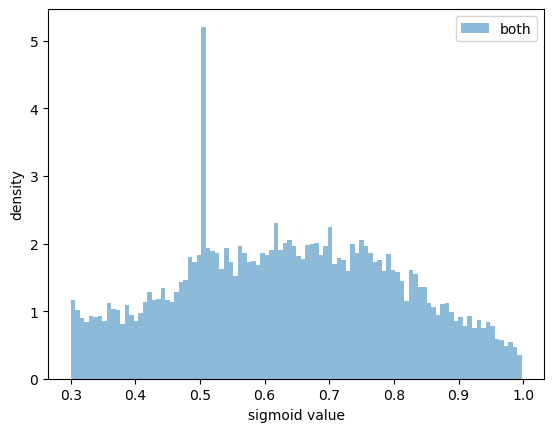

In [36]:
def show_logits_confusion_density():
    model.eval()
    logits = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)
            logits.append(torch.sigmoid(model(data)).squeeze().cpu().numpy())
            y_true.append(data.y.cpu().numpy())
    logits = np.concatenate(logits)
    y_true = np.concatenate(y_true)
    plt.hist(logits[y_true == 0], bins=100, alpha=0.5, label='0', density=True)
    plt.xlabel('sigmoid value')
    plt.ylabel('density')
    plt.legend()
    plt.show()
    plt.hist(logits[y_true == 1], bins=100, alpha=0.5, label='1', density=True)
    plt.xlabel('sigmoid value')
    plt.ylabel('density')
    plt.legend()
    plt.show()
    plt.hist(logits[logits > 0.3], bins=100, alpha=0.5, label='both', density=True)
    plt.xlabel('sigmoid value')
    plt.ylabel('density')
    plt.legend()
    plt.show()
show_logits_confusion_density()

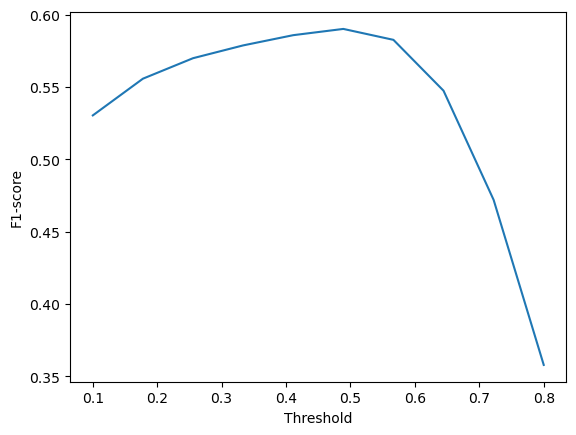

In [37]:
# on peut revenir à un modèle intermédiaire pour éviter l'overfitting
epoch_opt = 7
model.load_state_dict(torch.load("training_states/"+str(epoch_opt)+".pth"))

T = np.linspace(0.1,0.8,10)
f1s = []
for t in T:
    model.set_threshold(t)
    f1_valid = aja.f1_score_moyen(model, validation_graphs)
    f1s.append(f1_valid)

plt.plot(T, f1s)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.show()

In [22]:
# quand on est content on fait une submission !
model.set_threshold(0.75)
aja.make_test_csv_submission(model, test_graphs, 'avec_toutes_les_donnees')